# **Подготовка модели для разработки веб-приложения для задач идентификации вредоносных интернет-ресурсов на основе методов машинного обучения**


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from urllib.parse import urlparse, unquote
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Подготовка датасета

<h2>Предварительная обработка датасета полученного от Urlhause</h2>

In [2]:
UrlHauseData = pd.read_csv('/tmp/URLHaus.csv')
UrlHauseData.head()

,Unnamed: 0,dateadded,url,url_status,last_online,threat,tags,urlhaus_link,reporter
0,0,2025-04-26 17:19:07 UTC,http://27.206.89.40:34443/bin.sh,online,2025-04-26 17:19:07 UTC,malware_download,"['32-bit', 'elf', 'mips', 'Mozi']",https://urlhaus.abuse.ch/url/3526769/,geenensp
1,1,2025-04-26 17:16:06 UTC,http://27.214.235.142:52638/i,online,2025-04-26 17:16:06 UTC,malware_download,"['32-bit', 'arm', 'elf', 'Mozi']",https://urlhaus.abuse.ch/url/3526768/,geenensp
2,2,2025-04-26 17:15:06 UTC,http://61.0.97.186:49514/i,online,2025-04-26 17:15:06 UTC,malware_download,"['32-bit', 'elf', 'mips', 'Mozi']",https://urlhaus.abuse.ch/url/3526767/,geenensp
3,3,2025-04-26 17:14:05 UTC,http://125.43.119.79:34409/i,online,2025-04-26 17:14:05 UTC,malware_download,"['32-bit', 'elf', 'mips', 'Mozi']",https://urlhaus.abuse.ch/url/3526766/,geenensp
4,4,2025-04-26 17:13:07 UTC,http://125.40.222.130:35441/bin.sh,online,2025-04-26 17:13:07 UTC,malware_download,"['32-bit', 'elf', 'mips', 'Mozi']",https://urlhaus.abuse.ch/url/3526765/,geenensp


In [3]:
UrlHauseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114858 entries, 0 to 114857
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    114858 non-null  int64 
 1   dateadded     114858 non-null  object
 2   url           114858 non-null  object
 3   url_status    114858 non-null  object
 4   last_online   103091 non-null  object
 5   threat        114858 non-null  object
 6   tags          112259 non-null  object
 7   urlhaus_link  114858 non-null  object
 8   reporter      114858 non-null  object
dtypes: int64(1), object(8)
memory usage: 7.9+ MB


*Удаление ненужных столбцов*

In [4]:
UrlHauseData = UrlHauseData.drop(['Unnamed: 0', 'dateadded', 'url_status', 'last_online', 'tags', 'urlhaus_link', 'reporter'], axis=1)
UrlHauseData.head()

,url,threat
0,http://27.206.89.40:34443/bin.sh,malware_download
1,http://27.214.235.142:52638/i,malware_download
2,http://61.0.97.186:49514/i,malware_download
3,http://125.43.119.79:34409/i,malware_download
4,http://125.40.222.130:35441/bin.sh,malware_download


*Переименуем столбец threat в type*

In [5]:
UrlHauseData = UrlHauseData.rename(columns={'threat': 'type'})
UrlHauseData.head()

,url,type
0,http://27.206.89.40:34443/bin.sh,malware_download
1,http://27.214.235.142:52638/i,malware_download
2,http://61.0.97.186:49514/i,malware_download
3,http://125.43.119.79:34409/i,malware_download
4,http://125.40.222.130:35441/bin.sh,malware_download


In [6]:
UrlHauseData['type'].value_counts()

,count
type,
malware_download,114858


*Значение malware_download говорит о принадлежности данного URL к классу malware, поэтому заменим эти значения на обобщенный вариант malware*

In [7]:
UrlHauseData['type'] = UrlHauseData['type'].replace('malware_download', 'malware')
UrlHauseData['type'].value_counts()

,count
type,
malware,114858


In [ ]:
UrlHauseData.head()

,url,type
0,http://27.206.89.40:34443/bin.sh,malware
1,http://27.214.235.142:52638/i,malware
2,http://61.0.97.186:49514/i,malware
3,http://125.43.119.79:34409/i,malware
4,http://125.40.222.130:35441/bin.sh,malware


<h2>Предварительная обработка датасета полученного от PhishTank</h2>

In [8]:
PhishTankData = pd.read_csv('/tmp/PhishTank.csv')
PhishTankData.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,9077369,https://e-zpass.com-etcdi.win/,http://www.phishtank.com/phish_detail.php?phis...,2025-04-26T17:03:00+00:00,yes,2025-04-26T17:11:46+00:00,yes,Other
1,9077368,https://mainnetconnect.github.io/authenticatio...,http://www.phishtank.com/phish_detail.php?phis...,2025-04-26T17:02:41+00:00,yes,2025-04-26T17:11:46+00:00,yes,Other
2,9077365,https://e-zpass.com-etcdk.win/,http://www.phishtank.com/phish_detail.php?phis...,2025-04-26T17:02:13+00:00,yes,2025-04-26T17:11:46+00:00,yes,Other
3,9077361,https://e-zpass.com-etcdl.win/,http://www.phishtank.com/phish_detail.php?phis...,2025-04-26T17:01:53+00:00,yes,2025-04-26T17:11:46+00:00,yes,Other
4,9077356,https://e-zpass.com-etcdo.win/,http://www.phishtank.com/phish_detail.php?phis...,2025-04-26T17:01:26+00:00,yes,2025-04-26T17:11:46+00:00,yes,Other


In [9]:
PhishTankData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62773 entries, 0 to 62772
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   phish_id           62773 non-null  int64 
 1   url                62773 non-null  object
 2   phish_detail_url   62773 non-null  object
 3   submission_time    62773 non-null  object
 4   verified           62773 non-null  object
 5   verification_time  62773 non-null  object
 6   online             62773 non-null  object
 7   target             62773 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.8+ MB


*Удаление ненужных столбцов*

In [10]:
PhishTankData = PhishTankData.drop(['phish_id', 'phish_detail_url', 'submission_time', 'verification_time', 'online', 'target'], axis=1)
PhishTankData.head()

,url,verified
0,https://e-zpass.com-etcdi.win/,yes
1,https://mainnetconnect.github.io/authenticatio...,yes
2,https://e-zpass.com-etcdk.win/,yes
3,https://e-zpass.com-etcdl.win/,yes
4,https://e-zpass.com-etcdo.win/,yes


*Переименуем столбец verified в type*

In [11]:
PhishTankData = PhishTankData.rename(columns={'verified': 'type'})
PhishTankData.head()

,url,type
0,https://e-zpass.com-etcdi.win/,yes
1,https://mainnetconnect.github.io/authenticatio...,yes
2,https://e-zpass.com-etcdk.win/,yes
3,https://e-zpass.com-etcdl.win/,yes
4,https://e-zpass.com-etcdo.win/,yes


In [12]:
PhishTankData['type'].value_counts()

,count
type,
yes,62773


*Значение yes говорит о принадлежности данного URL к классу phishing, поэтому заменим эти значения на обобщенный вариант phishing*

In [13]:
PhishTankData['type'] = PhishTankData['type'].replace('yes', 'phishing')
PhishTankData['type'].value_counts()

,count
type,
phishing,62773


In [14]:
PhishTankData.head()

,url,type
0,https://e-zpass.com-etcdi.win/,phishing
1,https://mainnetconnect.github.io/authenticatio...,phishing
2,https://e-zpass.com-etcdk.win/,phishing
3,https://e-zpass.com-etcdl.win/,phishing
4,https://e-zpass.com-etcdo.win/,phishing


<h2>Предварительная обработка датасета полученного от ThreatFox</h2>

In [15]:
ThreatFoxData = pd.read_csv('/tmp/ThreatFox.csv')
ThreatFoxData.head()

,Unnamed: 0,ioc_value,ioc_type,threat_type,malware,malware_alias,malware_printable,first_seen_utc,last_seen_utc,confidence_level,reference,tags,anonymous,reporter
0,0,https://xvigorbridgoe.top/banb,url,botnet_cc,win.lumma,LummaC2 Stealer,Lumma Stealer,2025-04-26 12:55:33,NaN,75,https://bazaar.abuse.ch/sample/da06e18622f8191...,lumma,0,abuse_ch
1,1,https://ubiosphxere.digital/tqoa,url,botnet_cc,win.lumma,LummaC2 Stealer,Lumma Stealer,2025-04-26 12:55:30,NaN,75,https://bazaar.abuse.ch/sample/da06e18622f8191...,lumma,0,abuse_ch
2,2,https://mediaflowq.run/aeui,url,botnet_cc,win.lumma,LummaC2 Stealer,Lumma Stealer,2025-04-26 12:55:26,NaN,75,https://bazaar.abuse.ch/sample/da06e18622f8191...,lumma,0,abuse_ch
3,3,http://117.209.1.114:53127/Mozi.m,url,payload_delivery,elf.mozi,NaN,Mozi,2025-04-26 12:40:04,NaN,50,NaN,NaN,0,sicehicetf
4,4,https://gocloudes.com/6a1F2b3C4d5E6f7A8b9C0d1E...,url,payload_delivery,unknown,NaN,Unknown malware,2025-04-26 11:43:10,NaN,100,NaN,CoreSecThree,0,monitorsg


In [16]:
ThreatFoxData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279684 entries, 0 to 279683
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         279684 non-null  int64 
 1   ioc_value          279684 non-null  object
 2   ioc_type           279684 non-null  object
 3   threat_type        279684 non-null  object
 4   malware            279684 non-null  object
 5   malware_alias      250134 non-null  object
 6   malware_printable  279684 non-null  object
 7   first_seen_utc     279684 non-null  object
 8   last_seen_utc      100966 non-null  object
 9   confidence_level   279684 non-null  int64 
 10  reference          17739 non-null   object
 11  tags               271979 non-null  object
 12  anonymous          279684 non-null  int64 
 13  reporter           279684 non-null  object
dtypes: int64(3), object(11)
memory usage: 29.9+ MB


*Удаление ненужных столбцов*

In [17]:
ThreatFoxData = ThreatFoxData[['ioc_value', 'threat_type']]
ThreatFoxData.head()

,ioc_value,threat_type
0,https://xvigorbridgoe.top/banb,botnet_cc
1,https://ubiosphxere.digital/tqoa,botnet_cc
2,https://mediaflowq.run/aeui,botnet_cc
3,http://117.209.1.114:53127/Mozi.m,payload_delivery
4,https://gocloudes.com/6a1F2b3C4d5E6f7A8b9C0d1E...,payload_delivery


*Переименуем столбец threat_type в type, а столбец ioc_value в url*

In [18]:
ThreatFoxData = ThreatFoxData.rename(columns={'threat_type': 'type', 'ioc_value': 'url'})
ThreatFoxData.head()

,url,type
0,https://xvigorbridgoe.top/banb,botnet_cc
1,https://ubiosphxere.digital/tqoa,botnet_cc
2,https://mediaflowq.run/aeui,botnet_cc
3,http://117.209.1.114:53127/Mozi.m,payload_delivery
4,https://gocloudes.com/6a1F2b3C4d5E6f7A8b9C0d1E...,payload_delivery


In [19]:
ThreatFoxData['type'].value_counts()

,count
type,
payload_delivery,183505
botnet_cc,96179


*Значения payload_delivery и botnet_cc говорят о принадлежности данного URL к классу malware, поэтому заменим эти значения на обобщенный вариант malware*

In [20]:
ThreatFoxData['type'] = ThreatFoxData['type'].replace('payload_delivery', 'malware')
ThreatFoxData['type'] = ThreatFoxData['type'].replace('botnet_cc', 'malware')
ThreatFoxData['type'].value_counts()

,count
type,
malware,279684


In [21]:
ThreatFoxData.head()

,url,type
0,https://xvigorbridgoe.top/banb,malware
1,https://ubiosphxere.digital/tqoa,malware
2,https://mediaflowq.run/aeui,malware
3,http://117.209.1.114:53127/Mozi.m,malware
4,https://gocloudes.com/6a1F2b3C4d5E6f7A8b9C0d1E...,malware


<h2>Предварительная обработка датасета полученного от Kaggle</h2>

In [22]:
KaggleData = pd.read_csv('/tmp/Kaggle.csv')
KaggleData.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


In [23]:
KaggleData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316254 entries, 0 to 316253
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     316254 non-null  object
 1   label   316254 non-null  object
 2   result  316254 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 7.2+ MB


*Удаление ненужных столбцов*

In [24]:
KaggleData = KaggleData[['url', 'label']]
KaggleData.head()

,url,label
0,https://www.google.com,benign
1,https://www.youtube.com,benign
2,https://www.facebook.com,benign
3,https://www.baidu.com,benign
4,https://www.wikipedia.org,benign


*Переименуем столбец label в type*

In [25]:
KaggleData = KaggleData.rename(columns={'label': 'type'})
KaggleData.head()

,url,type
0,https://www.google.com,benign
1,https://www.youtube.com,benign
2,https://www.facebook.com,benign
3,https://www.baidu.com,benign
4,https://www.wikipedia.org,benign


In [26]:
KaggleData['type'].value_counts()

,count
type,
benign,316254


*Значение benign говорит о принадлежности данного URL к классу legitimate, поэтому заменим эти значения на legitimate*

In [27]:
KaggleData['type'] = KaggleData['type'].replace('benign', 'legitimate')
KaggleData['type'].value_counts()

,count
type,
legitimate,316254


In [28]:
KaggleData.head()

,url,type
0,https://www.google.com,legitimate
1,https://www.youtube.com,legitimate
2,https://www.facebook.com,legitimate
3,https://www.baidu.com,legitimate
4,https://www.wikipedia.org,legitimate


<h2>Объединение полученных датасетов</h2>

In [29]:
newData = pd.concat([UrlHauseData, PhishTankData, ThreatFoxData, KaggleData], ignore_index=True)
newData.head()

,url,type
0,http://27.206.89.40:34443/bin.sh,malware
1,http://27.214.235.142:52638/i,malware
2,http://61.0.97.186:49514/i,malware
3,http://125.43.119.79:34409/i,malware
4,http://125.40.222.130:35441/bin.sh,malware


<a id="3"></a> <br>
# Информация об итоговом датасете

In [30]:
newData.head()

,url,type
0,http://27.206.89.40:34443/bin.sh,malware
1,http://27.214.235.142:52638/i,malware
2,http://61.0.97.186:49514/i,malware
3,http://125.43.119.79:34409/i,malware
4,http://125.40.222.130:35441/bin.sh,malware


In [31]:
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773569 entries, 0 to 773568
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     773569 non-null  object
 1   type    773569 non-null  object
dtypes: object(2)
memory usage: 11.8+ MB


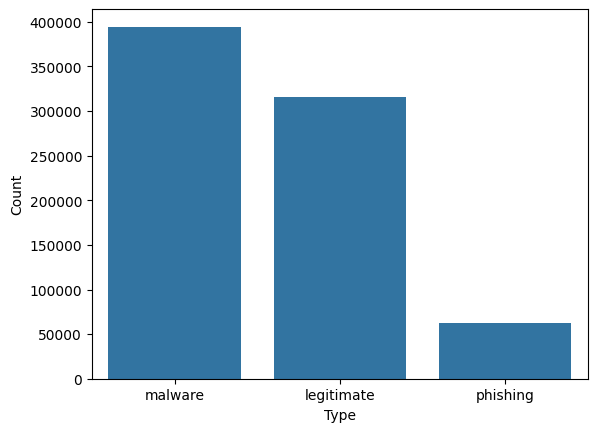

In [32]:
count = newData.type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Type')
plt.ylabel('Count');

<a id="4"></a>
# Предварительная обработка датасета

*Удаление "NaN" значений*

In [33]:
newData.dropna()

,url,type
0,http://27.206.89.40:34443/bin.sh,malware
1,http://27.214.235.142:52638/i,malware
2,http://61.0.97.186:49514/i,malware
3,http://125.43.119.79:34409/i,malware
4,http://125.40.222.130:35441/bin.sh,malware
...,...,...
773564,https://taekwondo.wisebytes.net/,legitimate
773565,https://www.steveconway.net/,legitimate
773566,https://www.tkd.net/,legitimate
773567,https://www.taekwondobible.com/,legitimate


In [34]:
newData.isnull().sum()

,0
url,0
type,0


*Удаление дубликатов*

In [35]:
newData = newData.drop_duplicates(subset='url', keep='first', ignore_index=True)

In [36]:
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772207 entries, 0 to 772206
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     772207 non-null  object
 1   type    772207 non-null  object
dtypes: object(2)
memory usage: 11.8+ MB


*Избавимся от "www."*

In [37]:
newData['url'] = newData['url'].replace('www.', '', regex=True)

In [38]:
newData.head()

,url,type
0,http://27.206.89.40:34443/bin.sh,malware
1,http://27.214.235.142:52638/i,malware
2,http://61.0.97.186:49514/i,malware
3,http://125.43.119.79:34409/i,malware
4,http://125.40.222.130:35441/bin.sh,malware


*Добавим численное представление legitimate, phishing, malware в столбец class*

In [39]:
rem = {"class": {"legitimate": 0, "phishing":1, "malware":2}}
newData['class'] = newData['type']
newData = newData.replace(rem)

<ipython-input-39-9044b6401c2c>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  newData = newData.replace(rem)


In [40]:
newData['class'].value_counts()

,count
class,
2,393197
0,316254
1,62756


In [41]:
newData.head()

,url,type,class
0,http://27.206.89.40:34443/bin.sh,malware,2
1,http://27.214.235.142:52638/i,malware,2
2,http://61.0.97.186:49514/i,malware,2
3,http://125.43.119.79:34409/i,malware,2
4,http://125.40.222.130:35441/bin.sh,malware,2


In [42]:
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772207 entries, 0 to 772206
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     772207 non-null  object
 1   type    772207 non-null  object
 2   class   772207 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 17.7+ MB


In [44]:
newData.to_csv('/tmp/FinalDataNew.csv', index=False)

# Объединение нового и старого датасетов

In [45]:
oldData = pd.read_csv('/tmp/FinalDataOld.csv')
oldData.head()

,Unnamed: 0,url,type,class
0,0,http://117.202.88.6:56947/bin.sh,malware,2
1,1,http://42.235.20.213:41718/i,malware,2
2,2,http://218.94.154.190:54555/Mozi.a,malware,2
3,3,http://223.112.39.21:44070/Mozi.m,malware,2
4,4,http://117.209.92.120:35822/Mozi.m,malware,2


In [46]:
oldData = oldData[['url', 'type', 'class']]
oldData.head()

,url,type,class
0,http://117.202.88.6:56947/bin.sh,malware,2
1,http://42.235.20.213:41718/i,malware,2
2,http://218.94.154.190:54555/Mozi.a,malware,2
3,http://223.112.39.21:44070/Mozi.m,malware,2
4,http://117.209.92.120:35822/Mozi.m,malware,2


In [47]:
oldData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732158 entries, 0 to 732157
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     732158 non-null  object
 1   type    732158 non-null  object
 2   class   732158 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.8+ MB


In [48]:
data = pd.concat([newData, oldData], ignore_index=True)
data = data.drop_duplicates(subset='url', keep='first', ignore_index=True)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198400 entries, 0 to 1198399
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   url     1198400 non-null  object
 1   type    1198400 non-null  object
 2   class   1198400 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 27.4+ MB


In [50]:
data.to_csv("/tmp/FinalData.csv", index=False)

<a id="5"></a> <br>
# Подготовка данных для обучения

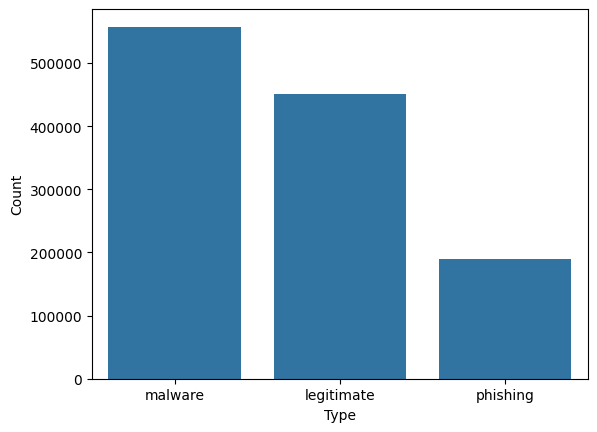

In [51]:
count = data.type.value_counts()
sns.barplot(x=count.index, y=count)
plt.xlabel('Type')
plt.ylabel('Count');

*Добавление столбца, содержащего длину URL*

In [52]:
data['length'] = data['url'].apply(lambda x: len(str(x)))

In [53]:
data.head()

,url,type,class,length
0,http://27.206.89.40:34443/bin.sh,malware,2,32
1,http://27.214.235.142:52638/i,malware,2,29
2,http://61.0.97.186:49514/i,malware,2,26
3,http://125.43.119.79:34409/i,malware,2,28
4,http://125.40.222.130:35441/bin.sh,malware,2,34


*Добавление столбца, содержащего длину домена URL*

In [54]:
data['domainLength'] = data['url'].apply(lambda i: len(urlparse(i).netloc))

In [55]:
data.head()

,url,type,class,length,domainLength
0,http://27.206.89.40:34443/bin.sh,malware,2,32,18
1,http://27.214.235.142:52638/i,malware,2,29,20
2,http://61.0.97.186:49514/i,malware,2,26,17
3,http://125.43.119.79:34409/i,malware,2,28,19
4,http://125.40.222.130:35441/bin.sh,malware,2,34,20


*Добавление столбцов, содержащих количество специальных символов в URL*



In [56]:
feature = ['@','?','-','=','.','#','+','$','!','*',',']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [57]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,#,+,$,!,*,","
0,http://27.206.89.40:34443/bin.sh,malware,2,32,18,0,0,0,0,4,0,0,0,0,0,0
1,http://27.214.235.142:52638/i,malware,2,29,20,0,0,0,0,3,0,0,0,0,0,0
2,http://61.0.97.186:49514/i,malware,2,26,17,0,0,0,0,3,0,0,0,0,0,0
3,http://125.43.119.79:34409/i,malware,2,28,19,0,0,0,0,3,0,0,0,0,0,0
4,http://125.40.222.130:35441/bin.sh,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0


*Добавление столбца, содержащего наличие закодированных символов в URL*

In [58]:
def encodedSymbolsCheck(url):
    decodedUrl = unquote(url)
    if url != decodedUrl:
        return 1
    else:
        return 0

In [59]:
data['isEncodedSymbols'] = data['url'].apply(lambda i: encodedSymbolsCheck(i))

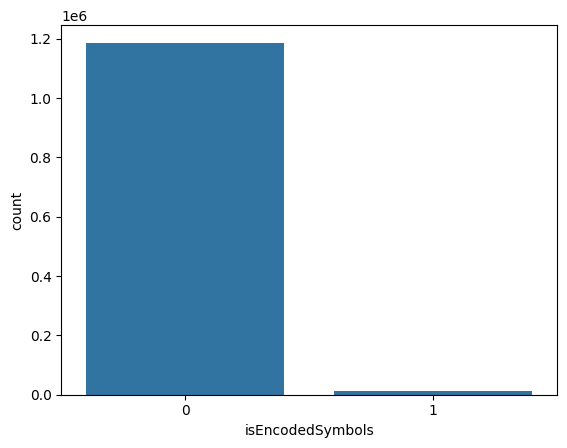

In [60]:
sns.countplot(x='isEncodedSymbols', data=data);

*Добавление столбца, содержащего наличие https протокола в URL*

In [61]:
def httpsCheck(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [62]:
data['isHttps'] = data['url'].apply(lambda i: httpsCheck(i))

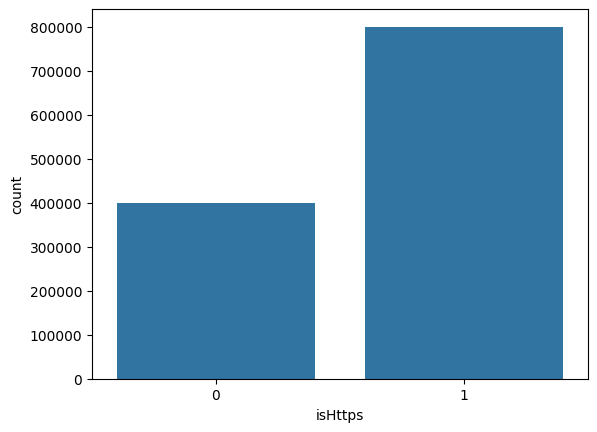

In [63]:
sns.countplot(x='isHttps', data=data);

*Добавление столбца, содержащего количестов цифр в URL*

In [64]:
def digitsCounter(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [65]:
data['digitsCount']= data['url'].apply(lambda i: digitsCounter(i))

In [66]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,#,+,$,!,*,",",isEncodedSymbols,isHttps,digitsCount
0,http://27.206.89.40:34443/bin.sh,malware,2,32,18,0,0,0,0,4,0,0,0,0,0,0,0,0,14
1,http://27.214.235.142:52638/i,malware,2,29,20,0,0,0,0,3,0,0,0,0,0,0,0,0,16
2,http://61.0.97.186:49514/i,malware,2,26,17,0,0,0,0,3,0,0,0,0,0,0,0,0,13
3,http://125.43.119.79:34409/i,malware,2,28,19,0,0,0,0,3,0,0,0,0,0,0,0,0,15
4,http://125.40.222.130:35441/bin.sh,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0,0,0,16


*Добавление столбца, содержащего количестов букв в URL*

In [67]:
def lettersCounter(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [68]:
data['lettersCount']= data['url'].apply(lambda i: lettersCounter(i))

In [69]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,#,+,$,!,*,",",isEncodedSymbols,isHttps,digitsCount,lettersCount
0,http://27.206.89.40:34443/bin.sh,malware,2,32,18,0,0,0,0,4,0,0,0,0,0,0,0,0,14,9
1,http://27.214.235.142:52638/i,malware,2,29,20,0,0,0,0,3,0,0,0,0,0,0,0,0,16,5
2,http://61.0.97.186:49514/i,malware,2,26,17,0,0,0,0,3,0,0,0,0,0,0,0,0,13,5
3,http://125.43.119.79:34409/i,malware,2,28,19,0,0,0,0,3,0,0,0,0,0,0,0,0,15,5
4,http://125.40.222.130:35441/bin.sh,malware,2,34,20,0,0,0,0,4,0,0,0,0,0,0,0,0,16,9


*Добавление столбца, содержащего информацию об применении сервисов для сокращения URL над исходным URL*

In [70]:
def shortiningServiceCheck(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [71]:
data['isShortiningService'] = data['url'].apply(lambda x: shortiningServiceCheck(x))

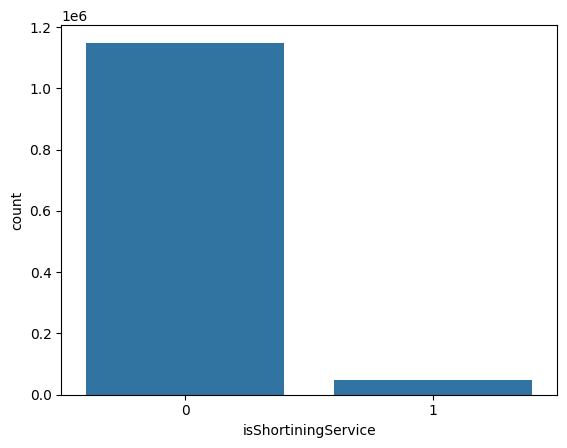

In [72]:
sns.countplot(x='isShortiningService', data=data);

*Добавление столбца, содержащего наличие IP адреса в URL*

In [73]:
def ipCheck(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [74]:
data['isIp'] = data['url'].apply(lambda i: ipCheck(i))

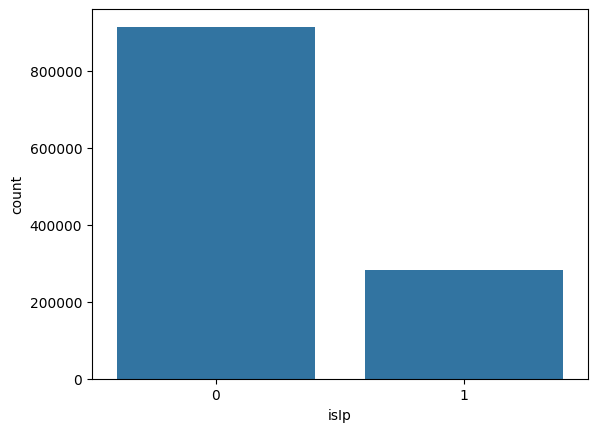

In [75]:
sns.countplot(x='isIp', data=data);

# Информация об конечном датасете

<Axes: >

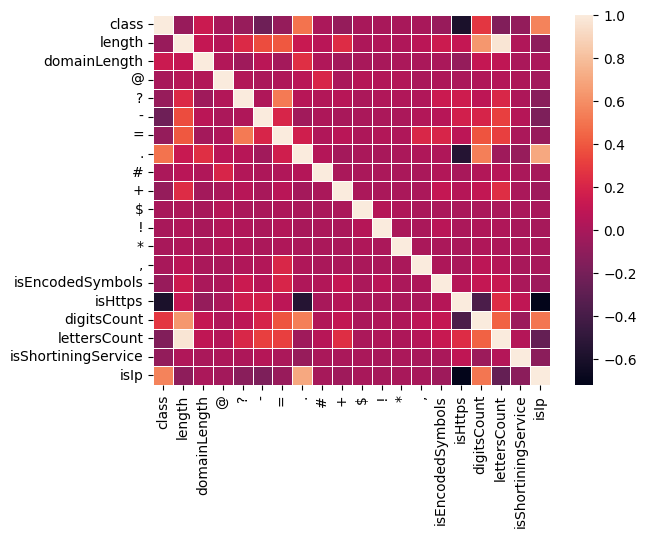

In [76]:
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), linewidths=.5)

In [77]:
data.head()

,url,type,class,length,domainLength,@,?,-,=,.,...,$,!,*,",",isEncodedSymbols,isHttps,digitsCount,lettersCount,isShortiningService,isIp
0,http://27.206.89.40:34443/bin.sh,malware,2,32,18,0,0,0,0,4,...,0,0,0,0,0,0,14,9,0,1
1,http://27.214.235.142:52638/i,malware,2,29,20,0,0,0,0,3,...,0,0,0,0,0,0,16,5,0,1
2,http://61.0.97.186:49514/i,malware,2,26,17,0,0,0,0,3,...,0,0,0,0,0,0,13,5,0,1
3,http://125.43.119.79:34409/i,malware,2,28,19,0,0,0,0,3,...,0,0,0,0,0,0,15,5,0,1
4,http://125.40.222.130:35441/bin.sh,malware,2,34,20,0,0,0,0,4,...,0,0,0,0,0,0,16,9,0,1


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198400 entries, 0 to 1198399
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   url                  1198400 non-null  object
 1   type                 1198400 non-null  object
 2   class                1198400 non-null  int64 
 3   length               1198400 non-null  int64 
 4   domainLength         1198400 non-null  int64 
 5   @                    1198400 non-null  int64 
 6   ?                    1198400 non-null  int64 
 7   -                    1198400 non-null  int64 
 8   =                    1198400 non-null  int64 
 9   .                    1198400 non-null  int64 
 10  #                    1198400 non-null  int64 
 11  +                    1198400 non-null  int64 
 12  $                    1198400 non-null  int64 
 13  !                    1198400 non-null  int64 
 14  *                    1198400 non-null  int64 
 15  ,              

# Разбиение датасета на обучающий и тестовый наборы

In [79]:
X = data.drop(['url','type','class'], axis=1)
y = data['class']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Обучение и тестирование модели

Model => RandomForestClassifier() 
Test Accuracy :  93.04%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     89908
           1       0.89      0.87      0.88     38109
           2       0.95      0.96      0.95    111663

    accuracy                           0.93    239680
   macro avg       0.92      0.92      0.92    239680
weighted avg       0.93      0.93      0.93    239680

             Confusion_matrix 


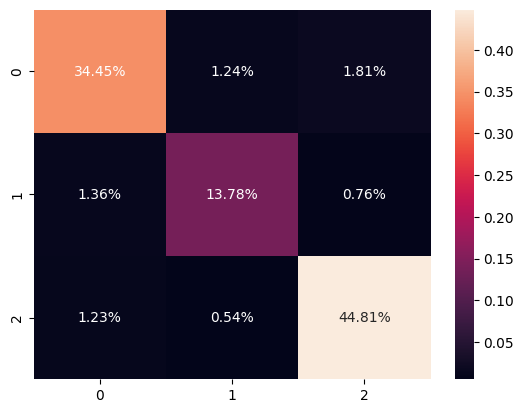

In [81]:
model_ = RandomForestClassifier()
model_.fit(X_train, y_train)
pred = model_.predict(X_test)
acc = accuracy_score(pred, y_test)

print('Model =>\033[07m {} \033[0m'.format(model_))
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()

# Сохранение модели

In [ ]:
from joblib import dump, load

dump(model_, '/tmp/trained_model.joblib')

['/tmp/trained_model.joblib']